## Applicazione del transfer learning con MobileNet_V2
A high-quality, dataset of images containing fruits. The following fruits are included: Apples - (different varieties: Golden, Golden-Red, Granny Smith, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red), Cactus fruit, Carambula, Cherry, Clementine, Cocos, Dates, Granadilla, Grape (Pink, White, White2), Grapefruit (Pink, White), Guava, Huckleberry, Kiwi, Kaki, Kumsquats, Lemon (normal, Meyer), Lime, Litchi, Mandarine, Mango, Maracuja, Nectarine, Orange, Papaya, Passion fruit, Peach, Pepino, Pear (different varieties, Abate, Monster, Williams), Pineapple, Pitahaya Red, Plum, Pomegranate, Quince, Raspberry, Salak, Strawberry, Tamarillo, Tangelo.

Training set size: 28736 images.

Validation set size: 9673 images.

Number of classes: 60 (fruits).

Image size: 100x100 pixels.

In [59]:
import numpy as np
import keras
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D, Cropping2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.keras.applications.mobilenet_v2  import MobileNetV2
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras import backend as K

### Change the path of directories!!!

In [3]:
# Setting path location for validation, traing and testing images
validationPath = 'D:/DataSet Storage/FRUTTA/Validation'
trainPath = 'D:/DataSet Storage/FRUTTA/Training'

### Plot an image, for example E:/Training/Cocos/15_100.jpg

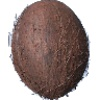

In [22]:
from IPython.display import Image as image_show
image_show('D:/DataSet Storage/FRUTTA/Training/Cocos/15_100.jpg', width = 200, height = 200)

### Now you define the functions ables to read mini-batch of data

In [7]:
# Making an image data generator object with augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

In [6]:
# Making an image data generator object with no augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)

### why train_datagen and test_datagen are different? answer . . .

The idea for manipulating the train data set using rotation, zoom, width/height shift, flipping and process such like is that to expose the model with all probably possible samples that it may deal with on prediction/classification phase. So to streghten the model and getting the most information from train data, we manipulate the samples in train set such that the manipulated samples also can be valid and possible samples as part of train set. But if we do the same process on validation and test sets we will increase the correlation between train and validation/test sets that is in conflict with the assumtion that sample are independent. That causes generally more accuracy on validation and test sets which is not real. To recap, it is recommended that do manipulation just on seen data rather than unseen data.        

In [8]:
# Using the generator with batch size 32 for training directory
train_generator = train_datagen.flow_from_directory(trainPath, 
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 28736 images belonging to 60 classes.


In [9]:
# Using the generator with batch size 17 for validation directory
validation_generator = test_datagen.flow_from_directory(validationPath,
                                                        target_size=(224, 224),
                                                        batch_size=17,
                                                        class_mode='categorical')

Found 9673 images belonging to 60 classes.


### you can control the dimensions of the generator outputs

In [10]:
validation_generator[0][0].shape

(17, 224, 224, 3)

In [11]:
validation_generator[0][1].shape

(17, 60)

### Now you need to define your model . . .
the default definition of MobileNet_V2 is:

MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

but you have a different number of classes . . . . .

In [53]:
mnv2 = MobileNetV2(weights=None, classes=60)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [82]:
model = Sequential()
model.add(InputLayer(input_shape = (224,224,3)))
model.add(Cropping2D(cropping=((2, 2), (2, 2))))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5),strides=(5,5)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(60, activation='softmax'))

### Define what layers you want to train . . .

In [83]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_6 (Cropping2D)    (None, 220, 220, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 216, 216, 16)      1216      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 39, 39, 32)        12832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                50208     
__________

### Compile the model . . .

In [84]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

## to fit the model you can write an expression as:
history = model.fit_generator(train_generator,
                              epochs=20,validation_data=validation_generator,)

In [85]:
history = model.fit_generator(train_generator,
                              epochs=20,validation_data=validation_generator)

Epoch 1/20


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_input_16_0_0}}]]

### Fine tuning?

### once you have obtained the final estimate of the model you must evaluate it with more details . . .

### take an image of a papaya from internet and try to apply your model . . .